In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [2]:
cwr = os.getcwd().strip('/notebooks')
index = pd.read_csv(f'/{cwr}/raw_data/index.csv')
metadata = pd.read_csv(f'/{cwr}/raw_data/metadata.csv',index_col='class_id')
test = pd.read_csv(f'/{cwr}/raw_data/test.csv')
metadata.head()

,lego_ids,lego_names,minifigure_name
class_id,,,
1,[76115],['Spider Mech vs. Venom'],SPIDER-MAN
2,[76115],['Spider Mech vs. Venom'],VENOM
3,[76115],['Spider Mech vs. Venom'],AUNT MAY
4,[76115],['Spider Mech vs. Venom'],GHOST SPIDER
5,[75208],"[""Yoda's Hut""]",YODA


In [3]:
images = []
tests = []
for path in index['path']:
    image = np.asarray(Image.open(f'/{cwr}/raw_data/{path}')\
        .resize((224, 224))
        )
    images.append(image)
for path in test['path']:
    image = np.asarray(Image.open(f'/{cwr}/raw_data/{path}')\
        .resize((224, 224))
        )
    tests.append(image)
images = np.stack(images,axis=0)
tests = np.stack(tests,axis=0)
images.shape, tests.shape

((371, 224, 224, 3), (79, 224, 224, 3))

In [4]:
X_train = images
X_test = tests

In [5]:
y_train = np.array(index['class_id'])-1
y_test = np.array(test['class_id'])-1

In [6]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras import layers, models

def create_model(input_shape):

    base_model = DenseNet201(input_shape = input_shape,
                       include_top = False,
                       weights = 'imagenet',
                       classifier_activation='softmax')

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.Flatten()(x)
    # x = layers.Dense(224, activation = 'relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(38, activation = 'softmax')(x)

    return models.Model(base_model.input,x)

2023-12-11 11:56:00.212883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-11 11:56:00.360271: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-11 11:56:01.004570: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/francois/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/tensorrt
2023-12-11 11:56:01.004642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    featurewise_center = False,
    featurewise_std_normalization = False,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    zoom_range = (0.8, 1.2),
    )

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [8]:
train_flow = train_datagen.flow(X_train, y_train, batch_size = 16)
valid_flow = test_datagen.flow(X_test, y_test, batch_size = 1)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

model = create_model((224,224,3))
model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = Adam(learning_rate=0.001),
             metrics = ['accuracy'])
es = EarlyStopping(monitor = 'val_loss',
                               patience = 6,
                               mode = 'min',
                               restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3,
                              min_lr=0.00001)
with tf.device('/GPU:0'):
    history = model.fit(
        train_flow,
        validation_data = valid_flow,
        epochs = 100,
        verbose=1,
        callbacks = [es,reduce_lr]
        )

2023-12-11 11:56:02.014868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 11:56:02.021304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 11:56:02.021362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-11 11:56:02.021770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Epoch 1/100


2023-12-11 11:56:18.287099: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


 1/24 [>.............................] - ETA: 4:33 - loss: 5.5346 - accuracy: 0.0000e+00

2023-12-11 11:56:19.981323: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


24/24 [==============================] - 23s 465ms/step - loss: 16.9135 - accuracy: 0.2022 - val_loss: 11.9734 - val_accuracy: 0.3291 - lr: 0.0010
Epoch 2/100
24/24 [==============================] - 8s 329ms/step - loss: 2.7811 - accuracy: 0.6873 - val_loss: 7.1674 - val_accuracy: 0.5190 - lr: 0.0010
Epoch 3/100
24/24 [==============================] - 8s 322ms/step - loss: 1.5210 - accuracy: 0.8410 - val_loss: 4.9745 - val_accuracy: 0.6456 - lr: 0.0010
Epoch 4/100
24/24 [==============================] - 8s 319ms/step - loss: 0.6044 - accuracy: 0.9003 - val_loss: 3.7328 - val_accuracy: 0.6709 - lr: 0.0010
Epoch 5/100
24/24 [==============================] - 7s 306ms/step - loss: 0.5534 - accuracy: 0.9218 - val_loss: 5.3612 - val_accuracy: 0.6582 - lr: 0.0010
Epoch 6/100
24/24 [==============================] - 7s 305ms/step - loss: 0.5689 - accuracy: 0.9299 - val_loss: 4.2377 - val_accuracy: 0.6835 - lr: 0.0010
Epoch 7/100
24/24 [==============================] - 8s 328ms/step - loss

In [10]:
model.evaluate(valid_flow)

79/79 [==============================] - 5s 64ms/step - loss: 2.0404 - accuracy: 0.7722


[2.0403800010681152, 0.7721518874168396]

In [11]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    # ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    # ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

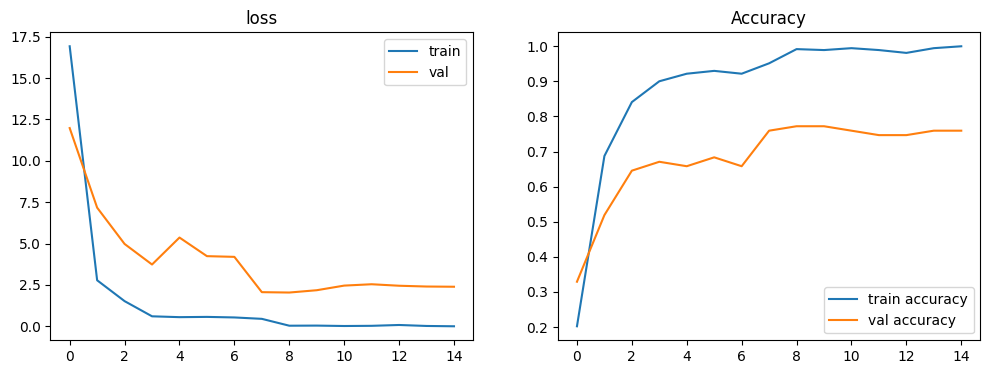

In [12]:
plot_history(history, title='small dataset', axs=None, exp_name="")

In [15]:
X_pred_1 = np.asarray(Image.open(f'/{cwr}/raw_data/test/001.jpg').resize((224, 224)))
X_pred_2 = np.asarray(Image.open(f'/{cwr}/raw_data/test/006.jpg').resize((224, 224)))
preds = np.stack((X_pred_1,X_pred_2),axis=0) / 255
preds.shape

(2, 224, 224, 3)

In [16]:
prediction = model.predict(preds)
(np.argmax(prediction[0]),prediction[0,np.argmax(prediction[0])]),(np.argmax(prediction[1]),prediction[1,np.argmax(prediction[1])])

1/1 [==============================] - 0s 110ms/step


((31, 0.99999976), (36, 0.9999485))